# Part2 - Neural Networks

In this part we aim to build a manual neural network based on SGD, and to optimize it's structure using grid search and genetic algorithm method.

In [11]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
from tqdm import tqdm
from tqdm import trange
from sklearn.metrics import roc_auc_score, roc_curve
import time
import pickle
from sklearn.preprocessing import MinMaxScaler
import itertools # iterations creator

In [12]:
data = pd.read_csv('..\\dataset_ver1.csv')

# PreProcess
### Create dataset

Unlike in Bayesian case, neural network input should contain as much continuos values as possible

In [20]:
data.sort_values('date',ascending=True, inplace=True)

In [21]:
dataset = data[[u'action_type', 
                u'minutes_remaining', u'period', u'seconds_remaining', 
                u'shot_distance', u'shot_made_flag',u'shot_zone_area', 
                u'loc_x', u'loc_y', 
                u'shot_zone_basic', u'shot_zone_range',  u'shot_type', 
                u'position', u'season', u'is_home']]

### Filter outlier periods

In [22]:
dataset = dataset[dataset.period <=4] ### 4 and not 5 this time

### Label 

In [23]:
dataset.rename(columns={'shot_made_flag' : 'label'}, inplace=True)

### Position

In [24]:
def transpos(position):
    '''transfers position to numeric value (10-50)'''
    dic = {'Guard':15, 'Center':50, 'Forward':40, 'Guard-Forward':22, 'Center-Forward':48,
       'Forward-Center':42, 'Forward-Guard':28}
    return dic[position]

In [25]:
dataset['numpos'] = dataset.position.apply(transpos)

### Angle feature

In [26]:
dataset['angle'] = dataset.apply(lambda x: np.arctan(x.loc_y*1.0/(x.loc_x+0.001)), axis = 1)

### Shot type feature

In [27]:
for index, row in dataset.iterrows():
    ls_words = row['action_type'].split(' ')
    for wd in ls_words:
        dataset.set_value(index,wd ,1)

In [28]:
dataset = dataset.fillna(0)

In [29]:
new_dset = dataset[[ u'minutes_remaining', u'period', u'seconds_remaining',
       u'shot_distance', u'label', u'loc_x', u'loc_y',
       u'season', u'is_home', u'numpos', u'angle', u'Driving', u'No', u'Tip', u'Turnaround', u'Finger',
       u'Pullup', u'Roll', u'Running', u'Dunk', u'Putback', u'Pull-Up',
       u'Layup', u'Step', u'Cutting', u'Bank', u'Reverse', u'Fadeaway',
       u'Back', u'Alley', u'Jump', u'Hook', u'Slam', u'Floating', u'Oop']]

In [30]:
new_dset.shape

(406630, 35)

## Scale data using Min-Max Scaling between 0-1

In [14]:
'''transfrom all features valuse to scale between 0 and 1 using Min-Max'''
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
minmax_new_dset = pd.DataFrame(scaler.fit_transform(new_dset), columns=new_dset.columns)
minmax_new_dset.describe()

,minutes_remaining,period,seconds_remaining,shot_distance,label,loc_x,loc_y,season,is_home,numpos,...,Bank,Reverse,Fadeaway,Back,Alley,Jump,Hook,Slam,Floating,Oop
count,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,...,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000,406630.000000
mean,0.446306,0.486850,0.487648,0.144109,0.452045,0.497957,0.145621,0.512867,0.500096,0.430878,...,0.020124,0.018073,0.021024,0.018152,0.011209,0.649664,0.038312,0.006293,0.026648,0.011209
std,0.287715,0.372832,0.295821,0.115735,0.497696,0.219723,0.097717,0.499835,0.500001,0.389321,...,0.140424,0.133215,0.143465,0.133500,0.105279,0.477076,0.191950,0.079080,0.161054,0.105279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.000000,0.237288,0.023256,0.000000,0.394000,0.063947,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.416667,0.333333,0.491525,0.151163,0.000000,0.500000,0.101433,1.000000,1.000000,0.714286,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.666667,0.745763,0.267442,1.000000,0.600000,0.228225,1.000000,1.000000,0.714286,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We tried to normalize the data to mean 0 and std 1, poor results due to redundant of binary variables

#### Save preprocessed data to csv:

In [15]:
'''this saving is in order to reduce pre process time '''
minmax_new_dset.to_csv(os.getcwd()+'\\minmax.csv',index=False)

#### Load preprocesses csv:

In [16]:
minmax_new_dset = pd.read_csv(os.getcwd()+'\\minmax.csv')

## Divide the data to train , validation and test

In [17]:
TrainProp=0.7 #0.7
validationsize = 0.1
train=minmax_new_dset.sample(frac=TrainProp,random_state=200)
test=minmax_new_dset.drop(train.index)
validation = test.sample(frac=validationsize/(1.0-TrainProp),random_state=200)
test=test.drop(validation.index)

In [18]:
train.shape, validation.shape, test.shape

((284641, 35), (40663, 35), (81326, 35))

# Model

# Part2  - SGD code

In [19]:
'''defining energy function (error function) logloss'''
def logloss(Y,Z, deriv=False):
    if deriv:
        return -Y*1.0/Z + (1.0-Y)/(1-Z)
    else:
        return -Y*np.log(Z) - (1-Y)*np.log(1-Z)

In [20]:
def quadloss(Y,Z, deriv=False):
    if deriv:
        return (Z-Y)
    else:
        return 0.5*((Z-Y)**2)

In [21]:
'''defining activation function'''
def sigmoid(x):
    ''' sigmoid function'''
    output = 1/(1+np.exp(-x))
    return output

def sigmoid_derivative(output):
    return output*(1-output)

In [22]:
def nnet_structure_init(in_list, bias = True, randrange = 1.0):
    ''' takes as input list of neurons in each layer, output will be list of synapses (matrices)'''
    net = []
    # in_list where in_list[0] is the input layer, in+list[-1] is the output layer
    for l in range(len(in_list)-1):
        syn = 2.0*randrange*np.random.random((in_list[l]+int(bias),in_list[l+1])) -randrange*1.0
        net.append(syn)
    return net

In [23]:
def nnet_run(net, X, Y, epochs=50000, alpha =0.01, bias=True, batchsize = 200, diminish=1.0, prints=0.1, loss=quadloss, goal_error = 0.1):
    '''takes net structure and run the X and Y (batches) on it epochs times, return update net'''
    errors = [] # errors values via the run
    pbar = xrange(iterations)
    for j in pbar:
        sample_idx = np.random.randint(low=0, high=X.shape[0], size=batchsize)
        Xn = X[sample_idx,:]
        Yn = Y[sample_idx,:]
        
        # feed forward
        l = [Xn] # first layer value = input
        for i in range(len(net)): #feed forward via synapses
            if bias: # add vector of -1s to current layer (all except last layer)
                l[-1] = np.concatenate((l[-1],-1*np.ones((l[-1].shape[0],1))), axis=1)
            l.append(sigmoid(np.dot(l[i],net[i])))

        # Cost - error function
        err = loss(Yn,l[-1], deriv=True) # deriv of error cost - d the output and label
        realerr= loss(Yn,l[-1], deriv=False)
        errors.append(np.mean(np.abs(realerr)))
        
        if j%int(epochs*0.01)==0.0:
            err_to_print = np.mean(errors[max(-100,-len(errors)):])
            if err_to_print<=goal_error:
                print "Stopped with error (overfitting):" ,err_to_print
                break # stop condition
        if j%int(epochs*prints)==0.0:
            err_to_print = np.mean(errors[max(-100,-len(errors)):])
            print "Epoch:",j,"Error:", str(err_to_print),time.ctime()
#             pbar.set_description('epoch: '+str(j)+' error: '+str(round(np.mean(np.abs(err)),3)))
        
        #back-propagation
        for i in range(len(net),0,-1): # run over synapses backwards
            delta = err*sigmoid_derivative(l[i]) # delta in i synapses
            if i<=len(net)-1 and bias:
                delta = np.delete(delta,-1,axis=1) # remove bias row from synapses matrix
            # print 'i',i, 'error:',error.shape,'delta:',delta.shape, 'net',net[i-1].shape
            err = delta.dot(net[i-1].T)
            net[i-1] -= alpha*l[i-1].T.dot(delta) # update synapse
        # diminishing alpha
        alpha = alpha*diminish
    return net, errors


In [24]:
def predict(X,net,bias = True):
    'return the prediction'
    l = [X] # first layer value = input
    for i in range(len(net)): #feed forward via synapses
        if bias: # add vector of -1s to current layer (all except last layer)
            l[-1] = np.concatenate((l[-1],-1*np.ones((l[-1].shape[0],1))), axis=1)
        l.append(sigmoid(np.dot(l[i],net[i])))
    return l[-1]

In [25]:
# plot error
def plot_error(alphas,errorlists,smooth=1):
    fig  = plt.figure()
    for a in range(len(alphas)):
        iterations = len(errorlists[a])
        err =[]
        for i in range(len(errorlists[a])):
            err.append(np.mean((errorlists[a][max(0,i-smooth):i])))
        ax =plt.plot(range(iterations),err)
    plt.title('Errorrate over epochs')
    plt.ylim([0,1.1])
    plt.xlim(-0.02*iterations,iterations)
    leg = plt.legend(map(lambda x: 'alpha: '+str(x),alphas))
    return fig

In [26]:
#plot ROC
def plot_ROC(nets,alphas,X,Y, bias = True, title =""):
    AUC = []
    fig2  = plt.figure()
    for net in nets:
        y_true ,y_scores = Y,  predict(X,net, bias = bias)
        fpr, tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
        AUC.append(roc_auc_score(y_true, y_scores))
        plt.xlim([-0.02,1.01])
        plt.ylim([-0.01,1.02])
        ax =plt.plot(fpr, tpr)
    leg = zip(alphas,AUC)
    plt.title(title)
    l = plt.legend(map(lambda x: 'params: '+str(x[0])+' AUC:'+str(round(x[1],3)),leg), loc = 4)
    return fig2, AUC

## Our data

In [35]:
np.random.seed(777) # note the seed here

trainsize = 284641
B = True
iterations = 500000 
batchsize=500
prints=0.1
diminish=1.0
alpha=0.001

trainsize = min(trainsize,train.shape[0])
samp =  train.sample(trainsize)
cols = samp.columns.drop('label')
X = np.array(samp[cols])
Y = np.array(samp[['label']])

# loss, goal  = logloss, 0.2
loss,goal = quadloss, 0.02


print X.shape, Y.shape

inputSize = X.shape[1]
structure = [inputSize,50,35,1]

net = nnet_structure_init(structure, bias = B)
newnet,errors = nnet_run(net, X, Y, epochs=iterations, alpha=alpha, bias=B,
                         batchsize=batchsize, prints=prints, diminish=diminish, loss=loss, goal_error=goal)

(284641L, 34L) (284641L, 1L)
Epoch: 0 Error: 0.166902801808 Sat Dec 24 11:29:05 2016
Epoch: 50000 Error: 0.109513511862 Sat Dec 24 11:30:44 2016
Epoch: 100000 Error: 0.110343921349 Sat Dec 24 11:32:22 2016
Epoch: 150000 Error: 0.109679935241 Sat Dec 24 11:33:59 2016
Epoch: 200000 Error: 0.109039794289 Sat Dec 24 11:35:42 2016
Epoch: 250000 Error: 0.108642935552 Sat Dec 24 11:37:24 2016
Epoch: 300000 Error: 0.108892606268 Sat Dec 24 11:39:05 2016
Epoch: 350000 Error: 0.108557350238 Sat Dec 24 11:40:47 2016
Epoch: 400000 Error: 0.107917730631 Sat Dec 24 11:42:25 2016
Epoch: 450000 Error: 0.107649255071 Sat Dec 24 11:44:09 2016


### Saving network object

In [36]:
netobj = {'params':(trainsize,B,iterations,structure,alpha,batchsize), 'net':newnet, 'errors' : errors}
netobj['desc']= 'Tsize=%s_Bias=%s_iter=%s_struct=%s_alpha=%s_batch=%s'%netobj['params']
netobj['name'] = ('ANN SGD '+netobj['desc']+' '+time.ctime()).replace(' ','_').replace(',',"_").replace(':','_')

### save the networks to pickle file 

In [37]:
pickle.dump( netobj, open( os.getcwd()+'\\pickles\\'+netobj['name']+'.pkl', "wb" ) )

In [38]:
# unpickle
unpick = pickle.load(open( os.getcwd()+'\\pickles\\'+netobj['name']+'.pkl', "rb" ) )

## Example network:

### Training error

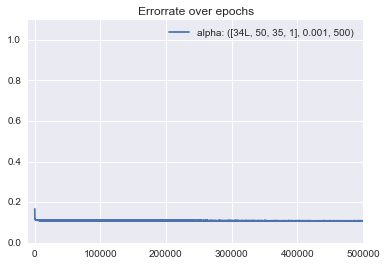

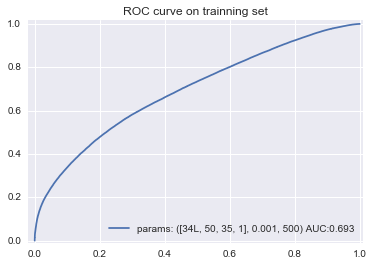

In [39]:
fe = plot_error([netobj['params'][-3:]],[netobj['errors']], smooth=200)
froc, AUC = plot_ROC([netobj['net']],[netobj['params'][-3:]],X,Y, bias = netobj['params'][1], title='ROC curve on trainning set')

In [40]:
fe.savefig(os.getcwd()+'\\figures\\'+'trainerror'+netobj['name']+'.pdf')
froc.savefig(os.getcwd()+'\\figures\\'+'trainROC'+netobj['name']+'.pdf')

### Validation

ROC of Validation set


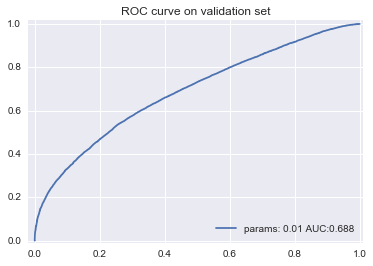

In [41]:
Xv = np.array(validation[cols])
Yv = np.array(validation[['label']])
print 'ROC of Validation set'
fvroc, vAUC = plot_ROC([newnet],[0.01],Xv,Yv, bias = True, title="ROC curve on validation set")
fvroc.savefig(os.getcwd()+'\\figures\\'+'valROC'+netobj['name']+'.pdf')

## Test performance (best configuration)

ROC of Test set


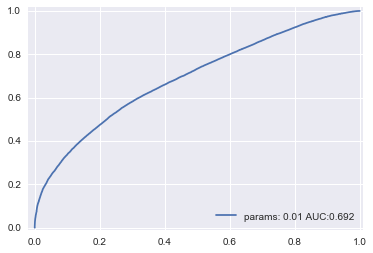

In [42]:
Xv = np.array(test[cols])
Yv = np.array(test[['label']])
print 'ROC of Test set'
fvroc, vAUC = plot_ROC([newnet],[0.01],Xv,Yv, bias = True)
fvroc.savefig(os.getcwd()+'\\figures\\'+'valROC'+netobj['name']+'.pdf')

# Results + Sensitivity analysis

We ran multiple simulations of network structure on external server, and here is the comparison:

In [31]:
def from_folder(path):
    dfs = [pd.read_csv("{}/{}".format(path, filename)) for filename in os.listdir(path)]
    df_ret = pd.concat(dfs)
    return df_ret

In [32]:
res = from_folder(os.getcwd()+'\\results')
res = res[res.columns[1:]]

In [33]:
def add_layers(row):
    '''decdode layers structure, converts the proportions to numbers'''
    hidden = [int(row[4])]
    for l in row.index[5:8]:
        if row[l]>0:
            hidden.append(int(hidden[-1]*row[l]))
    num = len(hidden)
    hidden = hidden + (4-len(hidden))*[0]
    row['hl2']=hidden[1]
    row['hl3']=hidden[2]
    row['hl4']=hidden[3]
    row['nhl'] = num
    row['hl12'] =str(int(row[4]))+' : '+str(hidden[1])
    row['totalnodes'] = round(int(row[4])+sum(hidden[1:]),-1)
    return row

In [34]:
results = res.apply(add_layers, axis = 1)
res = results[[u'alpha', u'batch', u'trainsize', u'epochs', u'trainerror', u'TrainAUC', u'ValAUC',u'hl1', u'hl2',
       u'hl3', u'hl4','nhl','hl12','totalnodes']]

In [36]:
res['trainsize'] = res.trainsize.apply(lambda x:min(x,284641) )  # fixing max train size

C:\Users\22334\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# By ALL

In [37]:
res.groupby(by=['trainsize','epochs','alpha','batch','nhl'])[['TrainAUC','ValAUC','trainerror']].mean()

TrainAUC    ValAUC  trainerror
trainsize epochs     alpha batch  nhl                                
2000.0    100000.0   0.010 100.0  1    0.937295  0.580701    0.184723
                                  2    0.967596  0.588763    0.059081
                                  3    0.970596  0.573794    0.040359
10000.0   100000.0   0.001 500.0  2    0.711320  0.662602    0.423715
                                  3    0.717361  0.658452    0.419068
                                  4    0.711247  0.659917    0.423183
                           2000.0 2    0.790554  0.617330    0.365937
                                  3    0.802894  0.616669    0.348957
                                  4    0.797318  0.620328    0.351209
                     0.010 500.0  2    0.858271  0.601985    0.279050
                                  3    0.883176  0.589948    0.245486
                                  4    0.887137  0.583062    0.258031
                           2000.0 2    0.894404  0.588991    0.203615
                                  3    0.912621  0.584070    0.189963
                                  4    0.905081  0.581458    0.209198
          200000.0   0.010 50.0   2    0.725684  0.653059    0.414735
                                  3    0.729642  0.649255    0.408992
                                  4    0.718951  0.651138    0.412695
284641.0  50000.0    0.010 50.0   2    0.678835  0.676337    0.441563
                                  3    0.675915  0.673522    0.441969
                                  4    0.654088  0.652069    0.449293
                           200.0  2    0.683707  0.681004    0.437802
                                  3    0.682757  0.680202    0.438671
                                  4    0.662264  0.659978    0.445064
                     0.100 50.0   2    0.684642  0.682060    0.435413
                                  3    0.682864  0.680464    0.437941
                                  4    0.661111  0.658867    0.444284
                           200.0  2    0.689572  0.685964    0.433572
                                  3    0.688925  0.685491    0.435300
                                  4    0.666406  0.663468    0.440214
                           2000.0 2    0.519607  0.519422    0.487840
                                  3    0.499999  0.499990    0.481783
                                  4    0.499998  0.500009    0.455657
                     1.000 50.0   2    0.661676  0.659024    0.442277
                                  3    0.670741  0.669190    0.430938
                                  4    0.645736  0.645785    0.436684
                           200.0  2    0.500000  0.500000    0.505856
                                  3    0.512222  0.512245    0.454890
                                  4    0.512277  0.525013    0.461141
                           2000.0 2    0.500000  0.500000    0.516213
                                  3    0.500000  0.500000    0.495046
                                  4    0.500000  0.500000    0.484051
          100000.0   0.001 400.0  2    0.682380  0.679462    0.440003
                     0.010 400.0  2    0.690592  0.686327    0.433375
                           500.0  3    0.692772  0.687490    0.436187
          500000.0   0.001 500.0  2    0.692606  0.688206    0.432709
                                  3    0.693053  0.688576    0.432228
                                  4    0.692560  0.688390    0.432267
                     0.010 500.0  2    0.697578  0.687489    0.429204
                                  3    0.698201  0.686889    0.428699
                                  4    0.698381  0.687215    0.429035
          10000000.0 0.010 1000.0 4    0.716502  0.664801    0.415642

# By Train Size

In [38]:
bysize = res.groupby(by=['trainsize'])[['TrainAUC','ValAUC','trainerror']].mean()
bysize

,TrainAUC,ValAUC,trainerror
trainsize,,,
2000.0,0.965562,0.581214,0.064721
10000.0,0.813300,0.617517,0.319089
284641.0,0.624072,0.621859,0.450983


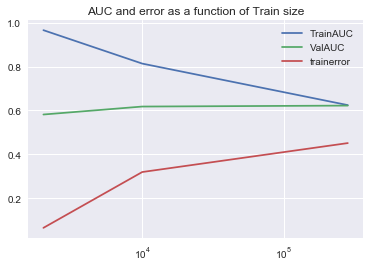

In [39]:
fig = plt.figure()
plt.plot(list(bysize.index),bysize['TrainAUC'])
plt.plot(list(bysize.index),bysize['ValAUC'])
plt.plot(list(bysize.index),bysize['trainerror'])
plt.legend(['TrainAUC','ValAUC','trainerror'])
plt.xscale('log')
t = plt.title('AUC and error as a function of Train size')

As train size increases, train error gets bigger, since the nnet has hard times to fit to the data.  
On the other hand, big train size makes the validation error slightly decrease.

# By training epochs

In [43]:
byep = res[res.trainsize>10000].groupby(by=['epochs'])[['TrainAUC','ValAUC']].mean()
byep

,TrainAUC,ValAUC
epochs,,
50000,0.610836,0.609725
100000,0.687184,0.683405
500000,0.695694,0.687719
10000000,0.716502,0.664801


In [12]:
np.log10(list(byep.index))

array([ 4.69897,  5.     ,  5.69897,  7.     ])

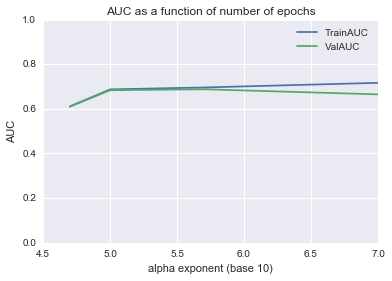

In [46]:
fig = plt.figure()
plt.plot(np.log10(list(byep.index)),byep['TrainAUC'])
plt.plot(np.log10(list(byep.index)),byep['ValAUC'])
# plt.plot(np.log10(list(byep.index)),byep['trainerror'])
plt.ylim([0,1.0])
# plt.xlim([42000, 550050])
# plt.xscale('log')
# plt.xticks(np.log10(list(byep.index)))
plt.legend(['TrainAUC','ValAUC','trainerror'])
plt.xlabel('alpha exponent (base 10)')
plt.ylabel('AUC')
t = plt.title('AUC as a function of number of epochs')

As epochs increase, the nnet performance improves, however we dont see major improvement when epochs>10000  
All the analysis from now on are made on the whole training set, hence we won't see overfitting.

# By alpha

In [19]:
bya = res[res.trainsize>10000].groupby(by=['alpha'])[['TrainAUC','ValAUC']].mean()
bya

,TrainAUC,ValAUC
alpha,,
0.001,0.691078,0.686941
0.010,0.681293,0.676275
0.100,0.622076,0.620140
1.000,0.557134,0.557724


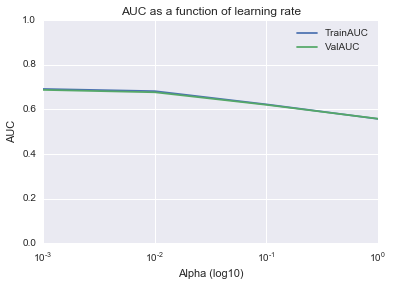

In [28]:
fig = plt.figure()
plt.plot(list(bya.index),bya['TrainAUC'])
plt.plot(list(bya.index),bya['ValAUC'])
# plt.plot(list(bya.index),bya['trainerror'])
plt.ylim([0,1.0])
plt.xscale('log')
#plt.yscale('log')
plt.xticks(list(bya.index))
plt.xlabel('Alpha (log10)')
plt.ylabel('AUC')
plt.legend(['TrainAUC','ValAUC','Train error'])
t = plt.title('AUC as a function of learning rate')

Small alpha, around 0.001  (best was found at 0.01), indicates good AUC for both train and validation sets.  
Big alpha don't give good results. prevents convergence

# By Batch size

In [20]:
byb = res[res.trainsize>10000].groupby(by=['batch'])[['TrainAUC','ValAUC']].mean()
byb

,TrainAUC,ValAUC
batch,,
50,0.670427,0.668375
200,0.623503,0.622609
400,0.686486,0.682895
500,0.695629,0.687714
1000,0.716502,0.664801
2000,0.502450,0.502426


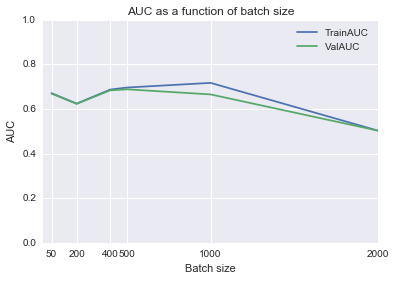

In [29]:
fig = plt.figure()
plt.plot(list(byb.index),byb['TrainAUC'])
plt.plot(list(byb.index),byb['ValAUC'])
# plt.plot(list(byb.index),byb['trainerror'])
plt.ylim([0,1.0])
#plt.xscale('log')
#plt.yscale('log')
plt.xticks(list(byb.index))
plt.xlabel('Batch size')
plt.ylabel('AUC')
plt.legend(['TrainAUC','ValAUC','Train error'])
t = plt.title('AUC as a function of batch size')

We can see a maximum AUC on 400-500 batch size. Bigger apparently says too much noise, prevents convergence (?)

# By Network stucture

In [30]:
res[res.trainsize>10000].groupby(by=['nhl','hl1'])[['TrainAUC','ValAUC']].mean()

TrainAUC    ValAUC
nhl hl1                    
2   20   0.652937  0.650692
    25   0.529411  0.529133
    30   0.659618  0.656995
    32   0.694724  0.687858
    40   0.650604  0.648015
    50   0.597906  0.593890
    100  0.500000  0.500000
3   20   0.655243  0.653327
    25   0.499998  0.499985
    30   0.650816  0.648774
    32   0.695258  0.688119
    40   0.650652  0.648455
    50   0.601965  0.597389
    100  0.500000  0.500000
4   20   0.598798  0.597592
    25   0.500000  0.500015
    30   0.653609  0.651932
    32   0.695020  0.688097
    40   0.648534  0.653066
    50   0.607267  0.599196
    100  0.500000  0.500000

In [74]:
res[res.trainsize>10000].groupby(by=['hl1','hl2','hl3','hl4'])[['TrainAUC','ValAUC','trainerror']].mean()

TrainAUC    ValAUC  trainerror
hl1 hl2 hl3 hl4                                
20  4   0   0    0.652195  0.649863    0.453868
        1   0    0.665983  0.663885    0.440015
        2   0    0.574531  0.573650    0.462162
    10  0   0    0.653151  0.650859    0.452418
        3   0    0.648865  0.646818    0.437195
        7   0    0.668435  0.666682    0.439296
            2    0.648524  0.646619    0.439498
    16  0   0    0.653465  0.651353    0.454695
        4   0    0.649218  0.647546    0.439183
        11  0    0.649896  0.647734    0.437225
            3    0.647870  0.646158    0.439441
25  5   0   0    0.588232  0.587399    0.469568
        1   0    0.500002  0.500041    0.455623
        3   0    0.500000  0.500007    0.452017
    12  0   0    0.500000  0.500000    0.548130
        3   0    0.500000  0.500000    0.451875
        8   0    0.499986  0.499855    0.471298
            2    0.500000  0.500046    0.458558
    20  0   0    0.500000  0.500000    0.453025
        6   0    0.500000  0.500000    0.500465
        14  0    0.500000  0.500000    0.502230
            4    0.500000  0.500000    0.451145
30  6   0   0    0.653465  0.651267    0.435531
        1   0    0.647296  0.645819    0.439021
        4   0    0.649614  0.647572    0.440972
            1    0.663836  0.662532    0.441051
    15  0   0    0.661770  0.658937    0.437858
        4   0    0.652380  0.649943    0.438358
        10  0    0.650750  0.648647    0.451609
            3    0.647858  0.645935    0.438829
...                   ...       ...         ...
40  32  22  6    0.649420  0.647606    0.454468
50  10  0   0    0.500000  0.500000    0.450230
        3   0    0.500000  0.500000    0.502145
        7   0    0.500000  0.500000    0.502835
            2    0.499992  0.499995    0.462300
    25  0   0    0.597799  0.594001    0.464253
        7   0    0.500000  0.500000    0.501390
        12  0    0.696872  0.687238    0.429241
            6    0.695561  0.687695    0.430623
        17  0    0.500000  0.500000    0.500390
            5    0.500000  0.500000    0.500110
    35  0   0    0.696829  0.687513    0.430103
        17  0    0.696927  0.686738    0.430175
            8    0.697992  0.686933    0.429380
    40  0   0    0.500000  0.500000    0.501435
        12  0    0.500000  0.500000    0.450690
        28  0    0.500000  0.500000    0.549350
            8    0.500000  0.500000    0.501530
100 20  0   0    0.500000  0.500000    0.499295
        6   0    0.500000  0.500000    0.498540
        14  0    0.500000  0.500000    0.500655
            4    0.500000  0.500000    0.499420
    50  0   0    0.500000  0.500000    0.549655
        15  0    0.500000  0.500000    0.450830
        35  0    0.500000  0.500000    0.548615
            10   0.500000  0.500000    0.453260
    80  0   0    0.500000  0.500000    0.548845
        24  0    0.500000  0.500000    0.452325
        56  0    0.500000  0.500000    0.500330
            16   0.500000  0.500000    0.450200

[83 rows x 3 columns]

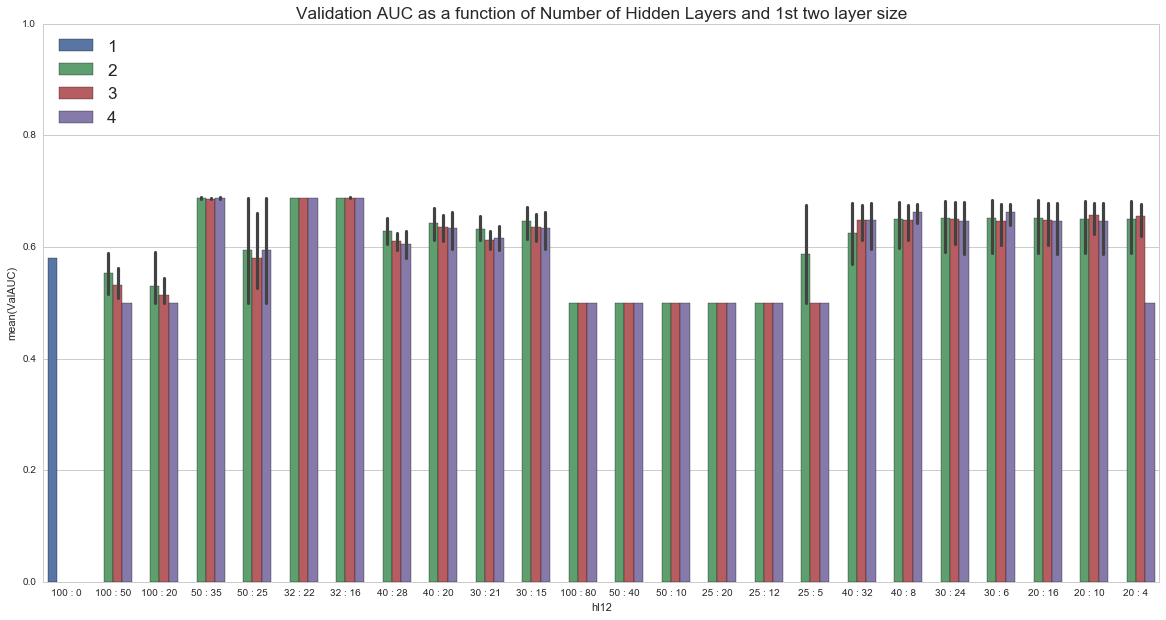

In [76]:
fig = plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="hl12", y="ValAUC", hue = "nhl", data=res)#, errwidth=0.0)
ax.legend(loc = 2,fontsize = 'xx-large')
plt.ylim([0.0,1.0])
tit = plt.title('Validation AUC as a function of Number of Hidden Layers and 1st two layer size', fontsize = 'xx-large')



Best validation AUC was achieved using 2 layers, with proportion of ~50:35, 32:22, 32:16

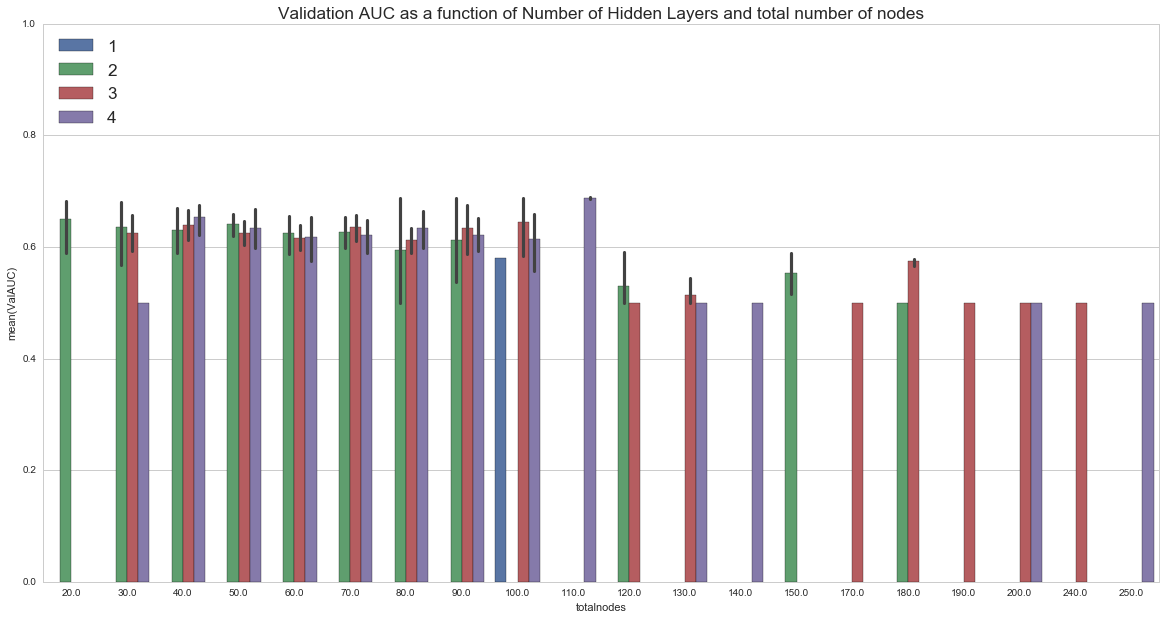

In [78]:
fig = plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="totalnodes", y="ValAUC", hue = "nhl", data=res)#, errwidth=1.0)
ax.legend(loc = 2,fontsize = 'xx-large')
plt.ylim([0.0,1.0])
tit = plt.title('Validation AUC as a function of Number of Hidden Layers and total number of nodes', fontsize = 'xx-large')

In [45]:
best = res.sort(columns='ValAUC',ascending=False).head(5)
best

C:\Users\Shuki\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,alpha,batch,trainsize,epochs,trainerror,TrainAUC,ValAUC,hl1,hl2,hl3,hl4,nhl,hl12,totalnodes
25,0.001,500,284641,500000,0.432074,0.693237,0.688970,50,35,17,8,4,50 : 35,110
26,0.001,500,284641,500000,0.433033,0.692874,0.688918,50,35,0,0,2,50 : 35,90
16,0.010,500,284641,500000,0.429991,0.696398,0.688882,32,16,8,0,3,32 : 16,60
27,0.001,500,284641,500000,0.431971,0.693212,0.688867,50,35,17,0,3,50 : 35,100
32,0.001,500,284641,500000,0.432293,0.693443,0.688830,50,35,17,0,3,50 : 35,100


## Bonus1 - [Genetic Notebook](Genetic.ipynb) 
implements genetic optimization algorithm in order to maximize AIC criteria

## Bonus2 - [Other Models Notebook](Other_models.ipynb) 
implements Random Forest, SVM and PCA in order to create benchmarks for prediction and find best features